# HW #2 Simple Spread Trading
[FINM 33150] Regression Analysis and Quantitative Trading Strategies\
Winter 2022 | Professor Brian Boonstra

_**Due:** Thursday, January 27th, at 11:00pm\
**Name:** Ashley Tsoi (atsoi, Student ID: 12286230)_

### 1. Fetch and clean data

#### 1-1. Import packages

In [33]:
import quandl
import json
import pandas as pd
pd.set_option("display.precision", 4)
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import math
import numpy as np
import datetime as dt
import functools

# let plot display in the notebook instead of in a different window
%matplotlib inline 
# from matplotlib import pyplot as plt
# import seaborn as sns
# import plotnine as p9

#### 1-2. Define the functions to fetch data from Quandl

**1-2-1. Get my personal keys** from ../data/APIs.json

In [3]:
f = open('../data/APIs.json')
APIs = json.load(f)
f.close()

**1-2-2. Define date-format helper function**

In [4]:
def assertCorrectDateFormat(date_text):
    try:
        dt.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect date format, should be YYYY-MM-DD")

# def strDateRngToDates(start_date,end_date):
#     d1 = dt.datetime.strptime(start_date, '%Y-%m-%d')
#     d2 = dt.datetime.strptime(end_date, '%Y-%m-%d')
#     d_diff = d2 - d1   # returns timedelta

#     date_range = [str(d1+dt.timedelta(days=i)) for i in range(d_diff.days+1)]
#     return ','.join(date_range)


**1-2-3. Define function** to retrieve raw data from Quandl

**Documentation:**
```
https://data.nasdaq.com/databases/EOD/usage/quickstart/python
```

In [21]:
# Define function that retrieves data from Quandl
def getQuandlEODData(secs,start_date,end_date):
    # Get one security (sec)'s data fom Quandl using quandl.get_table
    # NOTE: missing data for the inputted date will NOT return a row.

    # INPUT         | DATA TYPE                 | DESCRIPTION
    # sec           | string / list of string   | security name(s)
    # start_date    | string (YYYY-MM-DD)       | start date of data
    # end_date      | string (YYYY-MM-DD)       | end date of data (same as or after start_date)
    
    print("Quandl | START | Retriving Quandl data for securities: \n",secs)
    
    # Retrieve data using quandl.get_table
    quandl.ApiConfig.api_key = APIs['Quandl']
    data = quandl.get_table('QUOTEMEDIA/PRICES',
                            ticker = secs, 
                            date = {'gte':start_date, 'lte':end_date})

    print("Quandl | DONE  | Returning {:d} dates of data for {}.\n".format(len(data),secs))
    return data
    
@functools.lru_cache(maxsize=16) # Cache the function output
def getSpreadData(secs,start_date,end_date,N_window=15):

    # Input validation
    assert len(secs)==2 # secs must be a pair to calculate spread
    assertCorrectDateFormat(start_date)
    assertCorrectDateFormat(end_date)
    assert end_date >= start_date

    # Get Quandl Data
    if isinstance(secs, tuple): secs=list((secs))
    data = pd.DataFrame()
    for sec in secs:
        quandlData = getQuandlEODData(sec,start_date,end_date)[['date','adj_close','adj_volume']].set_index('date').sort_index(ascending=True)
        data[sec+'_adj_close'] = quandlData['adj_close']
        data[sec+'_N_t'] = (quandlData['adj_close']*quandlData['adj_volume']).rolling(N_window).median()

    # Get Fama French factor returns data
    print("FF     | START | Getting Fama-French returns data from CSV.\n")
    
    ff = pd.read_csv('../data/F-F_Research_Data_Factors_daily.CSV').rename(columns={'Unnamed: 0':'date'})
    ff['date'] = ff['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    ff = ff.set_index('date')[start_date:end_date]
    
    print("FF     | DONE  | \n")
    
    return pd.concat([data,ff],axis=1)

#### 1-3. Fetch cleaned spread data using functions above

Last 2 unique digits of my student ID: 3, 0

**Securities:**
```
Pair #0: FCOM VOX
```

**Securities Description:**
```
FCOM - Fidelity MSCI Communication Services Index ETF
VOX - Vanguard Communication Services ETF
```

**Dates:**
```
December 2, 2019 - December 31, 2021
```

In [22]:
secs,start_date,end_date = ("FCOM","VOX"),"2019-12-02","2021-12-31"
df = getSpreadData(secs,start_date,end_date)

Quandl | START | Retriving Quandl data for securities: 
 FCOM
Quandl | DONE  | Returning 526 dates of data for FCOM.

Quandl | START | Retriving Quandl data for securities: 
 VOX
Quandl | DONE  | Returning 526 dates of data for VOX.

FF     | START | Getting Fama-French returns data from CSV.

FF     | DONE  | 



In [36]:
secs,start_date,end_date = ("FCOM","VOX"),"2019-12-02","2021-12-31"
N_window=15
K=None
spread = getSpreadData(secs,start_date,end_date)
    
# set K to the maximum of N_t over the data period, times two
N_t_cols = spread.columns[spread.columns.str.endswith('_N_t')]
K = int(2*max(df[N_t_cols].max()))+1
# print("prep   |       | Setting initial capital (K) to {:d}.\n".format(K))

# print("prep   | DONE  | \n")
# print("trade  | START | \n")

tradeSim = spread[spread.columns[spread.columns.str.endswith('_adj_close')]] # initalize trade simulation table
tradeSim.head()


,FCOM_adj_close,VOX_adj_close
date,,
2019-12-02,34.1469,89.3003
2019-12-03,34.1273,89.1632
2019-12-04,34.2748,89.6723
2019-12-05,34.4125,89.9464
2019-12-06,34.6288,90.5143


In [41]:
N_window=15
M=10
j=0.05
g=0.1
s=1


for sec in secs:
    tradeSim[sec+'_M_day_cumret'] = (tradeSim[sec+'_adj_close'].pct_change()+1).rolling(M).apply(np.prod,raw=True)-1
    tradeSim[sec+'_quantity'] = [math.nan]*N_window + [int(s/100) for s in spread[sec+'_N_t'][N_window:]]

print("Spread | START | Calculating M-day cumulative return spread (X-Y) for X={}, Y={}.\n".format(secs[0],secs[1]))
tradeSim['cumret_spread'] = tradeSim[secs[0]+'_adj_close']-tradeSim[secs[1]+'_adj_close']
print("Spread | DONE  | \n")

# enter position if spread is above g, 
tradeSim['signal'] = [-1 if (r>g) else 1 if (r<-g) else 0 for r in tradeSim['cumret_spread']]
# close out position at end of every month
tradeSim['signal'] = 

# tradeSim.loc[tradeSim['signal']!=0]
position = tradeSim['signal'].diff()
tradeSim[secs[0]+'_pos'] = (position)*(tradeSim[secs[0]+'_quantity'])
tradeSim[secs[1]+'_pos'] = -1*(position)*(tradeSim[secs[0]+'_quantity'])

# tradeSim.loc['2019-12-20','K'] = K # init capital
# tradeSim['K'].fillna(0,inplace=True)
tradeSim['K'] = (K + (-1)*(tradeSim[secs[0]+'_pos']+tradeSim[secs[1]+'_pos'])).cumsum()
tradeSim['gross_cash'] = abs(tradeSim[secs[0]+'_pos'])+abs(tradeSim[secs[0]+'_pos'])

tradeSim

Spread | START | Calculating M-day cumulative return spread (X-Y) for X=FCOM, Y=VOX.

Spread | DONE  | 



,FCOM_adj_close,VOX_adj_close,FCOM_M_day_cumret,FCOM_quantity,VOX_M_day_cumret,VOX_quantity,cumret_spread,signal,FCOM_pos,VOX_pos,K,gross_cash
date,,,,,,,,,,,,
2019-12-02,34.1469,89.3003,NaN,NaN,NaN,NaN,-55.1533,1,NaN,NaN,NaN,NaN
2019-12-03,34.1273,89.1632,NaN,NaN,NaN,NaN,-55.0359,1,NaN,NaN,NaN,NaN
2019-12-04,34.2748,89.6723,NaN,NaN,NaN,NaN,-55.3975,1,NaN,NaN,NaN,NaN
2019-12-05,34.4125,89.9464,NaN,NaN,NaN,NaN,-55.5340,1,NaN,NaN,NaN,NaN
2019-12-06,34.6288,90.5143,NaN,NaN,NaN,NaN,-55.8855,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,52.0700,137.4700,0.0228,48568.0,0.0259,229849.0,-85.4000,1,0.0,-0.0,4.2429e+10,0.0
2021-12-28,51.9700,137.2300,0.0287,47444.0,0.0331,229849.0,-85.2600,1,0.0,-0.0,4.2512e+10,0.0
2021-12-29,51.7500,136.5000,0.0290,44330.0,0.0319,224433.0,-84.7500,1,0.0,-0.0,4.2596e+10,0.0


In [100]:

def spreadTradeSimulation(secs,start_date,end_date,N_window=15,M=10,j=0.05,g=0.1,s=1,K=None):
    
    print("========================================")
    print("prep   | START | Validating inputs.\n")
    
    assert j<g
    assert j>=0 # both j and g have to be positive
    assert s>0 and s<=1
    
    print("prep   |       | Getting spread data.\n")
    spread = getSpreadData(secs,start_date,end_date,N_window)
    
    if K==None:
        # set K to the maximum of N_t over the data period, times two
        N_t_cols = spread.columns[spread.columns.str.endswith('_N_t')]
        K = int(2*max(df[N_t_cols].max()))+1
        print("prep   |       | Setting initial capital (K) to {:d}.\n".format(K))
    
    print("prep   | DONE  | \n")
    print("trade  | START | \n")

    tradeSim = spread[['spread']] # initalize trade simulation table
    tradeSim['M_day_cumret'] = (tradeSim['spread'].pct_change()+1).rolling(M).cumprod()-1
    tradeSim['K'] = K # init capital
    for sec in secs:
        tradeSim[sec+'_quantity'] = int(spread[sec+'_N_t']/100)

    tradeSim['signal'] = [-1 if tradeSim['M_day_return']>g else 1 if tradeSim['M_day_return']<j else 0]
    tradeSim['position'] = tradeSim['signal'].diff()

    tradeSim['gross_cash'] = 

        


### 2. Analysis
#### 2-1. Characterize the relative dynamics of $s^{(i)}_t$

Examine more quantiles than just the median. Look at tails. 
Do the spreads correlate? How about their difference $(d)$ values? Do spreads exhibit patterns over time?

**2-1-1. Get more data for analysis**

1. The difference between the spreads  (pair 3 minus pair 0)
2. Rolling average prices with 20-day, 50-day, and 252-day windows
3. The "returns" for the spread pair (of securities `A` & `B` would bethe profit if we buy a share of `B` and sell a share of `A`)

**2-1-2. Define analysis functions**

In [11]:
def getStats(data,annual_factor=1):

    data_desc = data.describe().loc[['count','mean', 'max', 'min', 'std']]

    data_desc.loc['mean'] = data_desc.loc['mean']*annual_factor
    data_desc.loc['vol'] = data_desc.loc['std']*np.sqrt(annual_factor)
    data_desc.loc['sharpe_ratio'] = data_desc.loc['mean']/data_desc.loc['vol']

    data_desc.loc['skewness'] = data.skew()
    data_desc.loc['excess_kurtosis'] = data.kurt()-3
    data_desc.loc['VaR05'] = np.quantile(data, .05, axis=0)
    data_desc.loc['CVaR05'] = np.mean(data <= data_desc.loc['VaR05'])

    return data_desc
    

**2-1-3. General analysis of prices and returns of the spreads**

First look at the basic statistics of the prices and returns:

In [12]:
stats = pd.concat([getStats(spreads),getStats(spreads_ret,annual_factor=4)], axis=1)
stats.columns = pd.MultiIndex.from_arrays([['Prices']*3+['Returns']*3, stats.columns])
stats

Prices                              \
                ICE_T_T | ICE_G_G ICE_B_B | ICE_G_G         d   
count                    450.0000          450.0000  450.0000   
mean                      10.1931            7.1850    3.0081   
max                       22.0836           18.0436    9.8900   
min                        3.1376            1.2038   -0.9600   
std                        4.0781            3.5258    1.3401   
vol                        4.0781            3.5258    1.3401   
sharpe_ratio               2.4995            2.0378    2.2446   
skewness                   1.2007            1.0962    1.6819   
excess_kurtosis           -1.9598           -1.9902    5.2121   
VaR05                      4.9797            2.3591    1.8600   
CVaR05                     0.0511            0.0511    0.0556   

                          Returns                              
                ICE_T_T | ICE_G_G ICE_B_B | ICE_G_G         d  
count                    449.0000          449.0000  449.0000  
mean                       0.0193            0.0587    0.1667  
max                        0.5500            1.0536   10.0000  
min                       -0.4526           -0.6093   -1.2030  
std                        0.1095            0.1859    0.5701  
vol                        0.2190            0.3717    1.1403  
sharpe_ratio               0.0881            0.1579    0.1462  
skewness                   0.3606            1.4675   13.5298  
excess_kurtosis            0.4911            4.1355  215.4582  
VaR05                     -0.1609           -0.2376   -0.1298  
CVaR05                     0.0512            0.0512    0.0512

**The `mean`, `volatility`, and `sharpe_ratio` for "Returns" are annualized.*

Compared to the `ICE_B_B | ICE_G_G` (Brent Crude Oil - Gas Oil G) pair (pair #3), the `ICE_T_T | ICE_G_G` (WTI Crude Oil - Gas Oil G) pair (pair #0) has a higher mean of about $10.19 from 2019-12-03 to 2021-08-31. However, pair #0 has a lower annualized return (1.93%) compared to pair #3 (5.87%). With a lower volatility of 21.9%, pair #0 has an even higher sharpe ratio of 8.81%. 

Looking at the excess kurtosis of the spread *prices*, pair #0 have a slightly fatter tail than pair #3. However, if we look at the spread *returns*, pair #3 actually have a much fatter tail with excess kurtosis of ~4.14. This tells us that we have more extreme values the returns for the pair #3 compared to pair #0. However, looking at the conditional value at risk, or the expected shortfall, the two spread pairs are the same at 0.0512.

Next, let's see the time-series plots of the prices and returns, as well as their rolling averages.

<AxesSubplot:title={'center':'Futures Spread Rolling Average Prices (window=252)'}, xlabel='Date', ylabel='Prices ($)'>

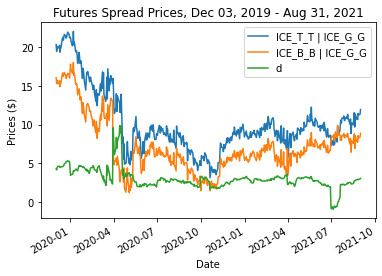

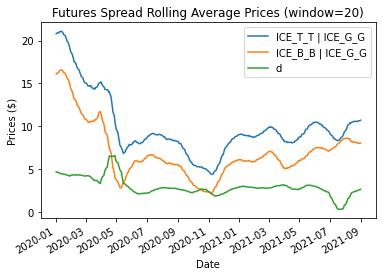

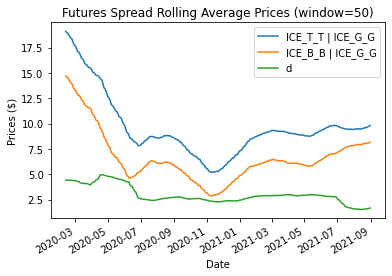

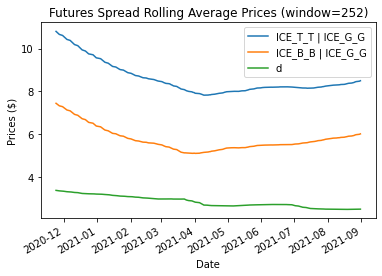

In [13]:
spreads.plot(ylabel="Prices ($)",title='Futures Spread Prices, Dec 03, 2019 - Aug 31, 2021')
prices_rolling_20[20:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=20)')
prices_rolling_50[50:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=50)')
prices_rolling_252[252:].plot(ylabel="Prices ($)",title='Futures Spread Rolling Average Prices (window=252)')

Looking at the prices charts, the two spread pairs do seem to have strong correlation.

In [14]:
prices_corr = spreads['ICE_B_B | ICE_G_G'].corr(spreads['ICE_T_T | ICE_G_G'])
print("The correlation between the prices of pair 0 and pair 3 is: {:.3f}".format(prices_corr))

The correlation between the prices of pair 0 and pair 3 is: 0.948


The correlation is extremely high througout the period. However, looking at the first chart above ('Futures Spread Prices, Dec 03, 2019 - Aug 31, 2021'), we can see that while pairs 0 and 3 rarely cross over, they do cross over in around July, 2021, leading to a close-to-zero `d` value. Let's see on which days do the pairs' prices cross over, and on which day does `d` have the lowest value.

In [15]:
d_crossOver = spreads.loc[spreads['d']<0]
display(d_crossOver)

d_minPrice_index = spreads.d.idxmin()
print("The date with the lowest price, ${:.2f}, for d is: {:%B %dth, %Y}.".format(spreads.d.loc[d_minPrice_index],d_minPrice_index))

,ICE_T_T | ICE_G_G,ICE_B_B | ICE_G_G,d
Date,,,
2021-06-30,7.7334,8.1334,-0.40
2021-07-01,7.3143,8.2043,-0.89
2021-07-02,7.9890,8.5590,-0.57
2021-07-05,7.3823,8.3423,-0.96
2021-07-06,8.0576,8.7176,-0.66
2021-07-07,7.3926,7.9326,-0.54
2021-07-08,7.5451,8.0651,-0.52
2021-07-09,8.3712,9.0712,-0.70
2021-07-12,8.1036,8.6736,-0.57


The date with the lowest price, $-0.96, for d is: July 05th, 2021.


Let's check the same thing with a 20-day rolling window.

In [16]:
d_roll20_crossOver = prices_rolling_20.loc[prices_rolling_20['d']<0]
display(d_roll20_crossOver)

d_roll20_minPrice_index = prices_rolling_20.d.idxmin()
print("With a rolling window of 20 days, the date with the lowest price, ${:.2f}, for d is: {:%B %dth, %Y}.".format(prices_rolling_20.d.loc[d_roll20_minPrice_index],d_roll20_minPrice_index))

,ICE_T_T | ICE_G_G,ICE_B_B | ICE_G_G,d
Date,,,


With a rolling window of 20 days, the date with the lowest price, $0.32, for d is: July 19th, 2021.


Since there are no periods when the prices cross over for a rolling window=20, we will just look at the prices chart (without rolling average) for trade signals. 

See how we would potentially perform by looking at the returns chart:

<AxesSubplot:title={'center':'Futures Spread Returns, Dec 03, 2019 - Aug 31, 2021'}, xlabel='Date', ylabel='Returns (%)'>

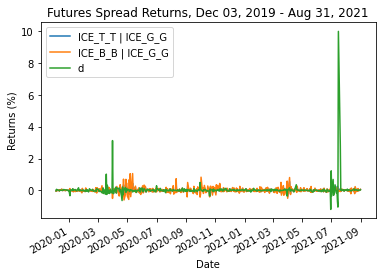

In [17]:
spreads_ret.plot(ylabel="Returns (%)",title='Futures Spread Returns, Dec 03, 2019 - Aug 31, 2021')

The return for `d` is really high for a period between 2021-07 and 2021-08. Let's find the specific date:

In [18]:
d_maxRet_index = spreads_ret.d.idxmax()
print("The date with the highest return, {:.2f}%, for d is: {:%B %dth, %Y}.".format(spreads_ret.d.loc[d_maxRet_index],d_maxRet_index))

The date with the highest return, 10.00%, for d is: July 16th, 2021.


***NOTE: buying `d` means "buy pair 3, sell pair 0"**, which is equal to: 
> buy (1/7.45) shares of `ICE_G_G`, sell 1 share of `ICE_T_T`, buy 1 share of `ICE_B_B`, and sell (1/7.45) shares of `ICE_G_G`

which is also equal to:
> sell 1 share of `ICE_T_T`, buy 1 share of `ICE_B_B`

It seems that the we get a high return for `d` on in 2021 July. This means (disregarding transaction costs and other real-life complications) if we buy of `ICE_B_B` and sell the same number of shares of `ICE_T_T`, we can get 10% returns on July 16th. 

However, how would we know ahead of time to enter the `d` trade before July 16th, 2021? We can look at the price cross-overs (when spread price difference `d` goes below $0$) as a signal to enter. 